# pyGMs Introduction: Exact and Approximate Variable Elimination

In [1]:
import numpy as np
np.random.seed(1234)
import pyGMs as gm
import matplotlib.pyplot as plt

Inference is the process of reasoning about the function defined by our graphical model, i.e., the combined influence of all of our factors.  Typical tasks are to compute the sum over all possible configurations, or "partition function", which corresponds to the normalizing constant of the function:
$$ Z = \sum_{x} \prod_\alpha f_\alpha(x_\alpha)$$
or the marginal distribution of some variable, say $X_i$, by summing over all variables except $X_i$ and normalizing:
$$ p(X_i) = \frac{1}{Z} \, \sum_{x_{\neg i}} \prod_\alpha f_\alpha(x_\alpha)$$
Maximization tasks compute the most probable configuration, or its value:
$$ x^* = \arg\max_{x} \prod_\alpha f_\alpha(x_\alpha)$$
$$ f^* = \max_{x} \prod_\alpha f_\alpha(x_\alpha)$$
More advanced queries may even interleave different types of elimination operations.

All these tasks involve the interactions of the entire model and all its factors on joint configurations of $x$, and thus cannot in general be answered without reasoning about the entire graph.

### Example Model

Let us first build a simple graphical model on which to perform our inference tasks:

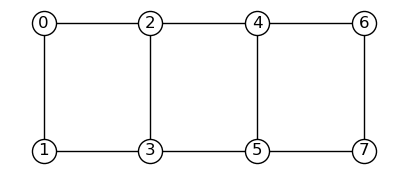

In [2]:
h,w = 2,4
X = [gm.Var(i,3) for i in range(h*w)]
tab = np.array([[1,0,0],[0,.9,0],[0,0,.8]])+.1
factors  = [gm.Factor([X[h*i+j],X[h*i+j+1]],tab) for i in range(w) for j in range(h-1)]
factors += [gm.Factor([X[h*i+j],X[h*i+j+h]],tab) for i in range(w-1) for j in range(h)]

pos = {i:(i//h,-(i%h)) for i in range(h*w)}

model = gm.GraphModel(factors)

fig,ax=plt.subplots(1,1,figsize=(5,2)); ax.set_axis_off();
gm.drawMarkovGraph(model,node_color='w',ax=ax, pos=pos);

### Basic Variable Elimination

We already know how to eliminate variables from our model, altering the structure and factors of our graph.  One way to compute the desired quantity by repeatedly eliminating variables along some order.  However, this will alter the graphical model itself; to avoid this, make a copy first:

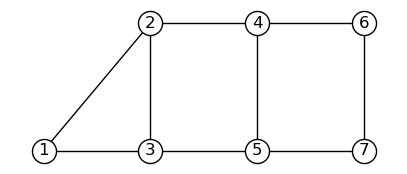

In [3]:
elim_model = model.copy()
elim_model.eliminate([0],'sum')

fig,ax=plt.subplots(1,1,figsize=(5,2)); ax.set_axis_off();
gm.drawMarkovGraph(elim_model,node_color='w',ax=ax, pos=pos);

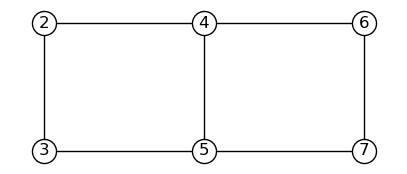

In [4]:
elim_model.eliminate([1],'sum')

fig,ax=plt.subplots(1,1,figsize=(5,2)); ax.set_axis_off();
gm.drawMarkovGraph(elim_model,node_color='w',ax=ax, pos=pos);

The `eliminate` function will also apply elimination sequentially along a desired order:

In [5]:
elim_model.eliminate([2,3,4,5,6,7],'sum')

print("Eliminating all variables leaves us with only a scalar factor:")
print(elim_model.factors)
print("with value:", elim_model.factors[0].table)
print("We can also access this with GraphModel.value([]):", elim_model.value([]))

Eliminating all variables leaves us with only a scalar factor:
SortedSet([Factor({},[0x6000004bb760])], key=<function factorSet.<locals>.<lambda> at 0x117e1dd00>)
with value: [4.56244407]
We can also access this with GraphModel.value([]): [4.56244407]


Variable elimination using `max` is equally simple:

In [6]:
elim_model = model.copy()
elim_model.eliminate([0,1,2,3,4,5,6,7],'max')
print("Max configuration value f* = ", elim_model.value([]) )

Max configuration value f* =  [2.59374246]


### Elimination Orders

The computational complexity of variable elimination depends on the structure of the graph and the order in which variables are eliminated.  In our (very regular) example, it is easy to see that the index order is a good one.  If we need to find an elimination order automatically, we can use various heuristic techniques to identify one, such as the "min width" or "min fill" heuristics.  For example:

In [7]:
order, score = gm.eliminationOrder(model, 'minfill')
print("order: ", order, ";   score:", score);  

order:  [0, 1, 2, 3, 4, 5, 6, 7] ;   score: 58.0


This function returns an order, along with a "score" corresponding to how large is the collection of intermediate functions that computed by elimination along this order.  This allows us to repeatedly run order searches, and identify better orders when we find them.  The keyword `nExtra` increases the amount of randomness in our search; the default value `nExtra=-1` is deterministic, while `nExtra=0` is greedy but breaks ties randomly, and increasing values of `nExtra` increase variability by making intermediate selections in the algorithm more random.

In [8]:
for i in range(10):
    print( gm.eliminationOrder(model, 'minfill', nExtra=1) )

([7, 6, 2, 1, 0, 4, 5, 3], 76.0)
([1, 6, 7, 0, 4, 5, 2, 3], 58.0)
([2, 1, 0, 3, 4, 5, 6, 7], 76.0)
([0, 6, 2, 3, 4, 1, 7, 5], 112.0)
([2, 6, 0, 3, 4, 1, 7, 5], 130.0)
([7, 6, 5, 4, 3, 0, 2, 1], 58.0)
([7, 0, 2, 6, 3, 1, 4, 5], 94.0)
([7, 6, 2, 5, 4, 0, 1, 3], 76.0)
([2, 6, 7, 5, 4, 1, 0, 3], 76.0)
([1, 0, 2, 6, 3, 4, 5, 7], 58.0)


Often we may want to make multiple order search attempts to find a good one.  The algorith can "short-circuit" a search and exit with no order if it is already worse than a previously found order, by using the `cutoff` keyword:

In [9]:
for i in range(10):
    print( gm.eliminationOrder(model, 'minfill', nExtra=1, cutoff=58) )

(None, 58)
([7, 0, 6, 1, 3, 5, 2, 4], 58.0)
(None, 58)
(None, 58)
(None, 58)
(None, 58)
(None, 58)
([1, 0, 3, 2, 5, 7, 6, 4], 58.0)
([1, 6, 0, 2, 7, 5, 3, 4], 58.0)
(None, 58)


#### PseudoTrees

Sometimes we want to reason about what *would* happen during variable elimination, without actually performing it.  For example, the preceding elimination process and order created factors with at most two variables at a time, since, for example, eliminating $X_0$ resulted in a new factor over $\{X_1,X_2\}$. This "largest clique size" during elimination is called the *induced width* of the elimination order.

A useful structure for representing the elimination process, without computing the factors and tables involved, is a **pseudotree**.  The pseudotree follows the elimination process, keeping track of what factors would be created and combined.  Some useful statistics of the resulting structure are its *width* (the number of arguments to the largest factor created during the elimination), and its *depth*, the longest sequence of dependencies during the elimination process.

In [10]:
pt = gm.PseudoTree(model, order)
print(f"PseudoTree has width {pt.width} and depth {pt.depth}")
print(f"Estimated computational effort is {pt.size}")

PseudoTree has width 2 and depth 7
Estimated computational effort is 58.0


### Junction Trees

However, the direct variable elimination process does not save the intermediate quantities needed for answering other queries, such as finding the configuration $x^*$ corresponding to value $f^*$, or computing marginal probabilities (other than that of the last eliminated variable).  These computations are usually performed using message passing on a junction tree or equivalent representation of the cliques.

The junction tree implementation is part of a more general approximation technique called weighted mini-bucket:

In [11]:
import pyGMs.wmb

order = [0,7,6,1,2,3,5,4]
jt = gm.wmb.JTree(model, order,'sum+')

(Here, "+" indicates that in the more general, WMB approximation, an upper bound should be computed.)

The junction tree representes the cliques that are reasoned about jointly during the elimination process, and how the results of each elimination are used in subsequent calculations.  We can use `networkx` to view the resulting tree and its associated cliques, which shows the flow of messages during the elimination process:

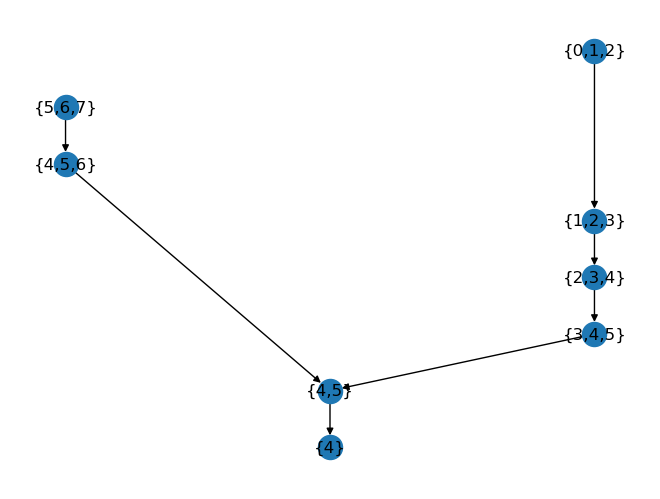

In [12]:
jt.draw();

So, for example, in this ordering, we eliminate $X_0$ first, collecting its factors (over clique $\{X_0,X_1,X_2\}$, and producing a new factor (message) over $\{X_1,X_2\}$, which is sent to its next relevant bucket: the (later) elimination of $X_1$, with clique $\{X_1,X_2,X_3\}$.  This order actually eliminates $X_7$ next (left branch), producing a message over $\{X_5,X_6\}$, which is sent to its next relevant bucket, over $\{X_4,X_5,X_6\}$.

The junction tree's internal representation gives a terse text-based version of the same information, i.e.:

In [13]:
jt

000: {0,1,2} => (3); 
007: {5,6,7} => (2); 
006: {4,5,6} => (6); 
001: {1,2,3} => (4); 
002: {2,3,4} => (5); 
003: {3,4,5} => (6); 
005: {4,5} => (7); 
004: {4} => (None); 

Each row corresponds to the elimination of a variable along our order, here $X_0$ to $X_7$; then we see the clique, or scope of the joint function computed.  So again, we see that when eliminating $X_0$, we reason about $(X_0,X_1,X_2)$, and the resulting quantity (a message involving $X_1$ and $X_2$) is passed along to be used in the elimination of $X_1$.

The "forward pass" on a junction tree computes the same quantity as elimination along that ordering, e.g.,

In [14]:
lnZ = jt.msgForward()
print("Log partition function: ",lnZ)
print("   (so, Z = ",np.exp(lnZ),")")

Log partition function:  1.5178584609923866
   (so, Z =  4.562444073600003 )


However, the junction tree also stores the intermediate computations, allowing us to then perform a backward pass to find any desired marginals, indicated by a list of `gm.VarSet`s.

In [15]:
queries = [ gm.VarSet([X[0]]) , gm.VarSet([X[2],X[3]]), gm.VarSet([X[5]]) ]
marginals = jt.beliefs( queries )
print(marginals)
print()
print("p(X0) = ", marginals[queries[0]].table)
print("p(X2,X3) = ", marginals[queries[1]].table)
print("...")

{{0}: Factor({0},[0x600000689dc0]), {2,3}: Factor({2,3},[0x600002590370]), {5}: Factor({5},[0x600000694500])}

p(X0) =  [0.6299893 0.2620805 0.1079302]
p(X2,X3) =  [[0.63671452 0.00263251 0.00208032]
 [0.00263251 0.25569223 0.00146849]
 [0.00208032 0.00146849 0.0952306 ]]
...


or, draw samples from the normalized version of the distribution:

In [16]:
for i  in range(5):
    print( jt.sample() )

({Var (4,3): 1, Var (5,3): 1, Var (3,3): 1, Var (2,3): 1, Var (1,3): 1, Var (6,3): 1, Var (7,3): 1, Var (0,3): 1}, -1.5178584609923857)
({Var (4,3): 0, Var (5,3): 0, Var (3,3): 0, Var (2,3): 0, Var (1,3): 0, Var (6,3): 0, Var (7,3): 0, Var (0,3): 0}, -0.5647566629491381)
({Var (4,3): 0, Var (5,3): 0, Var (3,3): 0, Var (2,3): 0, Var (1,3): 0, Var (6,3): 0, Var (7,3): 0, Var (0,3): 0}, -0.5647566629491381)
({Var (4,3): 0, Var (5,3): 0, Var (3,3): 0, Var (2,3): 0, Var (1,3): 0, Var (6,3): 0, Var (7,3): 0, Var (0,3): 0}, -0.5647566629491381)
({Var (4,3): 0, Var (5,3): 0, Var (3,3): 0, Var (2,3): 0, Var (1,3): 0, Var (6,3): 0, Var (7,3): 0, Var (0,3): 0}, -0.5647566629491381)


Note that computing the marginals requires that our junction tree is created using "sum" inference operations.  By computing a junction tree using "max" operations, we can find the value of, and a configuration for, the most probable state of the model:

In [17]:
jt = gm.wmb.JTree(model, order,'max+')
lnf = jt.msgForward()
print("Optimal log value: ",lnf)
print("   (so, f-star = ",np.exp(lnf),")")
print("An optimal configuration is: ")
print("  ",jt.argmax())

Optimal log value:  0.9531017980432495
   (so, f-star =  2.5937424601000023 )
An optimal configuration is: 
   {Var (4,3): 0, Var (5,3): 0, Var (3,3): 0, Var (2,3): 0, Var (1,3): 0, Var (6,3): 0, Var (7,3): 0, Var (0,3): 0}


### Weighted Mini-Bucket

If the exact variable elimination process is too computationally expensive, we can approximate it using "mini-buckets", which approximate the elimination at each step using an approximate elimination whose resulting function is made up of smaller, more managable factors, and which bounds the correct function in some way.

Mini-bucket does this by not combining all the factors of a given bucket, leaving multiple "mini-buckets", then eliminating separately in each mini-bucket.  We can see how this works in our working example:

In [18]:
wmb = gm.wmb.WMB(model, order,iBound=1, weights='sum+')
print(wmb)

000: {0,1}^0.50 => (3, 0); {0,2}^0.50 => (4, 0); 
007: {5,7}^0.50 => (6, 0); {6,7}^0.50 => (2, 0); 
006: {4,6}^1.00 => (7, 0); 
001: {1,3}^1.00 => (5, 0); 
002: {2,3}^0.50 => (5, 0); {2,4}^0.50 => (7, 0); 
003: {3,5}^1.00 => (6, 0); 
005: {4,5}^1.00 => (7, 0); 
004: {4}^1.00 => (None, None); 



This tells us that, when eliminating $X_0$, we group our factors into two sets, called mini-buckets: one including only variables $(X_0,X_1)$ and the other including only variables $(X_0,X_2)$. We then eliminate $X_0$ within each set separately, using a "weighted sum" with weight 0.5 in each mini-bucket, producing an upper bound on the true functon of $(X_1,X_2)$ defined by a function over only $X_1$ (which is passed to mini-bucket 0 in bucket 1, i.e., when eliminating $X_1$) and another function only over $X_2$ (which is passed to mini-bucket 0 of bucket 2, when $X_2$ is eliminated).  The computation never produces messages (intermediate factors) with more than `iBound` arguments, controlling the computational and memory complexity of the algorithm.  The `graphviz` visualization of the resulting mini-bucket tree shows this more graphically:

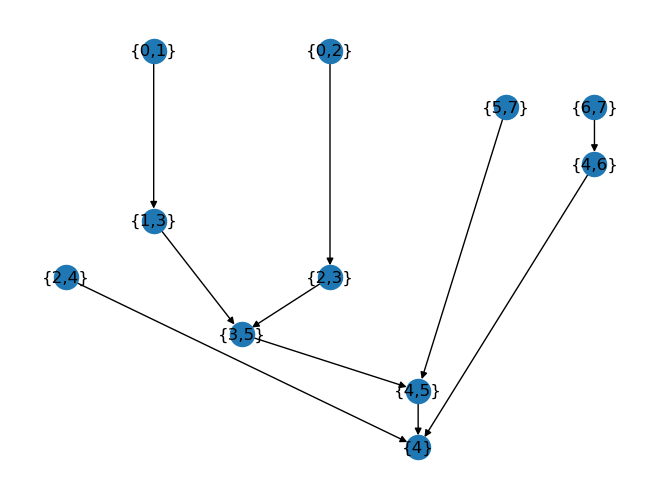

In [19]:
wmb.draw();

As with the junction tree, we can use a forward pass to compute the corresponding upper bound:

In [20]:
lnZ_bound = wmb.msgForward()
print("ln Z < ",lnZ_bound)

ln Z <  2.063330272548827


This is only an approximation, however, and can be tightened through changes to to allocation of factors to mini-buckets (called "reparameterization"), and by changes to the weights associated with each mini-bucket.  For example:

In [21]:
for step in range(4):
    wmb.msgBackward( stepTheta=.5, stepWeights=.2 )
    print("ln Z < ",wmb.msgForward())

ln Z <  2.0611901342020627
ln Z <  2.059631384404773
ln Z <  2.058482503849605
ln Z <  2.057626030226995


Each iteration tries to reduce the bound through a gradient update to the parameters and weights, with step sizes controlled by `stepTheta` (reparameterization changes) and `stepWeights` (weight changes).

As with the junction tree, this representation can be used to compute *approximate* marginals (called "beliefs"), or draw samples from a distribution that uses the mini-bucket bound to approximate the true distribution.

Using `weights=max+` produces a corresponding upper bound on the max-inference junction tree, which again can be tightened through reparameterization.  (Here, the weights are all zero and cannot be changed to tighten the bound.)

In [22]:
wmb = gm.wmb.WMB(model, order,iBound=1, weights='max+')
print("ln F* < ",wmb.msgForward())
for step in range(4):
    wmb.msgBackward( stepTheta=.5 )
    print("  ln F* < ",wmb.msgForward())

ln F* <  1.0001428257854852
  ln F* <  0.9993206974368367
  ln F* <  0.99901931747327
  ln F* <  0.998886503141341
  ln F* <  0.9988136360997613


As the complexity control parameter *iBound* increases, we reason about larger functions, until at some point the functions are sufficiently large to perform exact inference.  For example, in this model, the induced width is 2, so with iBound=3, we obtain the same results as the junction tree:

In [23]:
wmb3 = gm.wmb.WMB(model, order,iBound=3, weights='sum+')
print(wmb3)
print(f'With iBound=3, lnZ={wmb3.msgForward()}')

000: {0,1,2}^1.00 => (3, 0); 
007: {5,6,7}^1.00 => (2, 0); 
006: {4,5,6}^1.00 => (6, 0); 
001: {1,2,3}^1.00 => (4, 0); 
002: {2,3,4}^1.00 => (5, 0); 
003: {3,4,5}^1.00 => (6, 0); 
005: {4,5}^1.00 => (7, 0); 
004: {4}^1.00 => (None, None); 

With iBound=3, lnZ=1.5178584609923866


We can also start with a low-width minibucket model, and increase its width later by merging cliques or adding larger cliques.  For example: 

In [24]:
wmb = gm.wmb.WMB(model, order,iBound=1, weights='sum+')
print(f'iBound=1 lnZ={wmb.msgForward()}')
print()
print('Now, if we add a few, larger cliques, e.g., {0,1,2}, {5,6,7},')
wmb.addClique([0,1,2])
wmb.addClique([5,6,7])
print('we see that the resulting mini-bucket tree has a few larger cliques:')
print(wmb)
print(f'New WMB bound lnZ={wmb.msgForward()}')

iBound=1 lnZ=2.063330272548827

Now, if we add a few, larger cliques, e.g., {0,1,2}, {5,6,7},
we see that the resulting mini-bucket tree has a few larger cliques:
000: {0,1,2}^1.00 => (3, 1); 
007: {5,6,7}^1.00 => (2, 1); 
006: {4,6}^1.00 => (7, 0); {5,6}^0.00 => (6, 0); 
001: {1,3}^1.00 => (5, 0); {1,2}^0.00 => (4, 0); 
002: {2,3}^0.50 => (5, 0); {2,4}^0.50 => (7, 0); 
003: {3,5}^1.00 => (6, 0); 
005: {4,5}^1.00 => (7, 0); 
004: {4}^1.00 => (None, None); 

New WMB bound lnZ=2.06234673020125


With fewer approximations, this typically provides a better bound.  We can merge cliques automatically using some score function to tell us which cliques are valid to merge, and an order of preference; for example, the iBound mechanism can be reproduced using a simple merge strategy that allows merges up to scope size (number of variables) iBound, and prefers to merge larger cliques if possible, e.g.,

In [25]:
wmb.merge( wmb.scoreByScope(ibound=3) )
print(wmb)

000: {0,1,2}^1.00 => (3, 0); 
007: {5,6,7}^1.00 => (2, 0); 
006: {4,5,6}^1.00 => (6, 0); 
001: {1,2,3}^1.00 => (4, 0); 
002: {2,3,4}^1.00 => (5, 0); 
003: {3,4,5}^1.00 => (6, 0); 
005: {4,5}^1.00 => (7, 0); 
004: {4}^1.00 => (None, None); 

